#Импорты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.2 MB/s eta 0:00:00


In [3]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

#Загрузка и подготовка данных

In [ ]:
# Загрузка данных
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/data.json')
texts = df['text'].tolist()
# Приведение текстов к нижнему регистру
df['text'] = df['text'].str.lower()
labels = df['label'].tolist()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

0    cpu
1    ram
2    rom
3    usb
4    url
Name: text, dtype: object


In [7]:
# Токенизация
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Преобразование меток в числовой формат
label_map = {'abbreviation': 0, 'acronym': 1, 'autonym': 2, 'patronym': 3, 'real': 4}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
labels = [label_map[label] for label in labels]
# Проверка результата
print(df['text'].head())

#Подготовка

In [ ]:
# Класс датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        # Токенизация текста
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Параметры
MAX_LEN = 128
BATCH_SIZE = 16


# Разделим данные на обучающую и тестовую выборки
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


#Создание модели

In [8]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_map))
# Устройство (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

#Обучение модели

In [ ]:
# Оптимизатор
optimizer = AdamW(model.parameters(), lr=2e-5)
EPOCHS = 4

In [ ]:
# Метрики
accuracy = Accuracy(num_classes=len(label_map), average='macro', task='multiclass').to(device)
precision = Precision(num_classes=len(label_map), average='macro', task='multiclass').to(device)
recall = Recall(num_classes=len(label_map), average='macro', task='multiclass').to(device)
f1_score = F1Score(num_classes=len(label_map), average='macro', task='multiclass').to(device)

# Списки для метрик
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []

# Функция для обучения
def train_epoch(model, data_loader, optimizer):
    model = model.train()
    losses = []
    all_preds = []
    all_labels = []

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Прямой проход
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Обратный проход
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Обновление метрик
        accuracy.update(preds, labels)
        precision.update(preds, labels)
        recall.update(preds, labels)
        f1_score.update(preds, labels)

    avg_loss = sum(losses) / len(losses)

    # Получаем результаты метрик
    acc = accuracy.compute()
    prec = precision.compute()
    rec = recall.compute()
    f1 = f1_score.compute()

    # Сбрасываем метрики после каждой эпохи
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1_score.reset()

    return avg_loss, acc, prec, rec, f1

# Функция для оценки модели
def eval_model(model, data_loader):
    model = model.eval()
    losses = []
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Прямой проход
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            losses.append(loss.item())

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Вероятности классов
            probs = torch.nn.functional.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy())

            # Обновление метрик
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

    avg_loss = sum(losses) / len(losses)

    # Получаем результаты метрик
    acc = accuracy.compute()
    prec = precision.compute()
    rec = recall.compute()
    f1 = f1_score.compute()

    # Сбрасываем метрики после каждой эпохи
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1_score.reset()

    return avg_loss, acc, prec, rec, f1, all_probs, all_labels

# Обучение модели
for epoch in range(EPOCHS):
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(model, train_dataloader, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_probs, val_labels = eval_model(model, val_dataloader)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"Validation loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    # Сохранение метрик для графиков
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    train_precisions.append(train_prec.item())
    val_precisions.append(val_prec.item())
    train_recalls.append(train_rec.item())
    val_recalls.append(val_rec.item())
    train_f1_scores.append(train_f1.item())
    val_f1_scores.append(val_f1.item())

    # Построение ROC-кривой
    val_labels = np.array(val_labels)
    val_probs = np.array(val_probs)

# Отображение метрик
epochs = range(1, EPOCHS + 1)

Epoch 1/4
Train loss: 1.5038, Accuracy: 0.3458, Precision: 0.4756, Recall: 0.3458, F1: 0.3053
Validation loss: 0.9961, Accuracy: 0.5861, Precision: 0.5896, Recall: 0.5861, F1: 0.4854
Epoch 2/4
Train loss: 0.6924, Accuracy: 0.7431, Precision: 0.7598, Recall: 0.7431, F1: 0.7314
Validation loss: 0.4432, Accuracy: 0.7636, Precision: 0.6609, Recall: 0.7636, F1: 0.6909
Epoch 3/4
Train loss: 0.3382, Accuracy: 0.8258, Precision: 0.8255, Recall: 0.8258, F1: 0.8246
Validation loss: 0.3403, Accuracy: 0.9098, Precision: 0.9098, Recall: 0.9098, F1: 0.9059
Epoch 4/4
Train loss: 0.2282, Accuracy: 0.9184, Precision: 0.9199, Recall: 0.9184, F1: 0.9187
Validation loss: 0.2687, Accuracy: 0.9084, Precision: 0.9079, Recall: 0.9084, F1: 0.9051


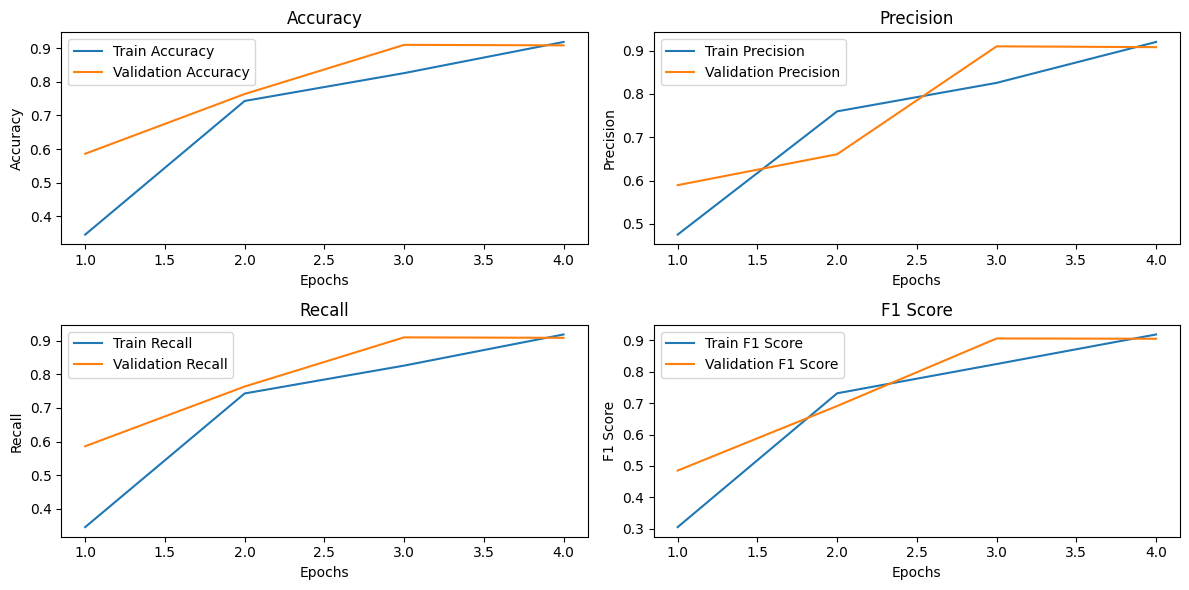

In [ ]:
# График точности
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# График прецизионности
plt.subplot(2, 2, 2)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

# График полноты
plt.subplot(2, 2, 3)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

# График F1
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score')

plt.tight_layout()
plt.show()

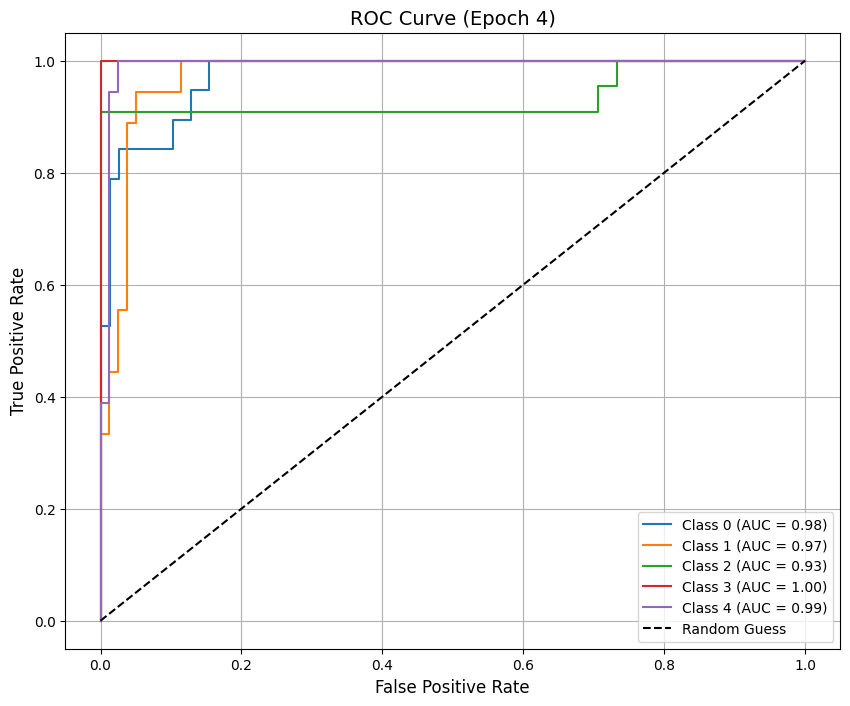

In [ ]:
# Рассчитаем ROC и AUC для каждого класса
plt.figure(figsize=(10, 8))

for i in range(len(label_map)):
    fpr, tpr, _ = roc_curve(val_labels == i, val_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Отображаем ROC кривую для класса
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Линия случайного угадывания (диагональ)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Настройки графика
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (Epoch {epoch + 1})', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

#Сохранене и использование модели

In [ ]:
# Сохранение модели
torch.save(model , '/content/drive/MyDrive/Colab Notebooks/ForNeural2/Roberta.pth')

In [9]:
# Загрузка модели
model = torch.load('/content/drive/MyDrive/Colab Notebooks/ForNeural2/Roberta.pth')
model.to(device)

<ipython-input-9-df33e5226182>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/ForNeural2/Roberta.pth')


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [10]:
def predict_with_classes(model, tokenizer, text, label_map, max_len=128):
    text = text.lower().replace(" ", "")
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy().flatten()

    # Обращаем словарь для индексации по числам
    index_to_label = {v: k for k, v in label_map.items()}

    # Создаем словарь {класс: вероятность}
    class_probs = {index_to_label[i]: prob for i, prob in enumerate(probs)}

    # Находим наиболее вероятный класс
    most_probable_class = index_to_label[probs.argmax()]
    max_probability = probs.max()

    return class_probs, most_probable_class, max_probability

In [ ]:
# Определение словаря меток
label_map = {'abbreviation': 0, 'acronym': 1, 'autonym': 2, 'patronym': 3, 'real': 4}

# Текст для анализа
text = "Michael Lazarev"

# Вызов функции
class_probs, most_probable_class, max_probability = predict_with_classes(model, tokenizer, text, label_map)

# Вывод всех классов с вероятностями
print("Class probabilities:")
for class_name, prob in class_probs.items():
    print(f"Class: {class_name}, Probability: {prob:.4f}")

# Вывод наиболее вероятного класса
print(f"\nMost probable class: {most_probable_class} (Probability: {max_probability:.4f})")

Class probabilities:
Class: abbreviation, Probability: 0.0018
Class: acronym, Probability: 0.0022
Class: autonym, Probability: 0.0022
Class: patronym, Probability: 0.0089
Class: real, Probability: 0.9849

Most probable class: real (Probability: 0.9849)


#Каково частотное распределение типов никнеймов в молодежной группе пользователей ВК? (18-25 лет)

In [ ]:
# Загрузка JSON-файлов
df1 = pd.read_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/usernames_fl.json')
df2 = pd.read_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/ds_18_25_filtered.json')

# Проверка структуры данных
print("df1 columns:", df1.columns)
print("df2 columns:", df2.columns)

# Объединение по 'id'
df2 = df2.merge(df1[['id', 'first_name', 'last_name']], left_on='id', right_on='id', how='left')

# Создание нового столбца 'text' из 'first_name' и 'last_name'
df2['text'] = df2['first_name'].fillna('') + ' ' + df2['last_name'].fillna('')

# Сохранение результата
df2.to_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/userswithnames.json', orient='records', force_ascii=False)

print("Объединение завершено, результат сохранен в userswithnames.json")

df1 columns: Index(['id', 'first_name', 'last_name'], dtype='object')
df2 columns: Index(['id', 'bdate', 'sex', '_id', 'city', 'occupation'], dtype='object')
Объединение завершено, результат сохранен в userswithnames.json


In [ ]:
dataset = pd.DataFrame(pd.read_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/userswithnames.json'))

In [ ]:
dataset.head()

,id,bdate,sex,_id,city,occupation,first_name,last_name,text
0,9a60db71-4309-441f-9180-c5e5e4cb23c8,17.10.2004,2,{'$oid': '66df66cf0a84abded3c99df1'},None,"{'id': 744, 'name': 'ПГУ', 'type': 'university...",Mark,Kus,Mark Kus
1,9294be27-2623-42dc-b4ce-87ccf3ebd73d,6.6.2005,1,{'$oid': '66df66d00a84abded3c99fee'},None,None,Ksenia,Grigorovich,Ksenia Grigorovich
2,9f443195-61a9-44a2-a66f-a852d847d548,17.7.2006,1,{'$oid': '66df66d30a84abded3c9ae6d'},None,None,Kamila,Abdukadyrova,Kamila Abdukadyrova
3,76948992-9d1c-4fb8-b6dc-108b42afc087,9.11.2000,2,{'$oid': '66df66d90a84abded3c9daf8'},"{'id': 73, 'title': 'Krasnoyarsk'}",None,Dima,Kotov,Dima Kotov
4,56ec394d-00d8-4ea5-9004-a1ae4d9927e8,23.11.2002,2,{'$oid': '66df66da0a84abded3c9dcaa'},None,None,Danil,Rozbitsky,Danil Rozbitsky


In [11]:
def predict_with_classes(model, tokenizer, text, label_map, max_len=128):
    text = text.lower().replace(" ", "")  # Приводим текст к нижнему регистру и убираем пробелы

    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy().flatten()

    # Обращаем словарь для индексации по числам
    index_to_label = {v: k for k, v in label_map.items()}

    # Создаем словарь {класс: вероятность}
    class_probs = {index_to_label[i]: prob for i, prob in enumerate(probs)}

    # Находим наиболее вероятный класс
    most_probable_class = index_to_label[probs.argmax()]
    max_probability = probs.max()

    return class_probs, most_probable_class, max_probability

In [12]:
predictions = []

# Применяем функцию к столбцу 'text' для предсказаний
def make_prediction(name):
    class_probs, most_probable_class, max_probability = predict_with_classes(
        model, tokenizer, name, label_map
    )
    return most_probable_class

In [ ]:
# Применяем функцию к каждому элементу столбца 'text' и добавляем результаты в новый столбец 'predictions'
dataset['predictions'] = dataset['text'].apply(make_prediction)
dataset.to_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/userswithnamesandpred.json', orient='records', force_ascii=False)

In [ ]:
dataset = pd.DataFrame(pd.read_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/userswithnamesandpred.json'))
print(dataset.head())

                                     id       bdate  sex  \
0  9a60db71-4309-441f-9180-c5e5e4cb23c8  17.10.2004    2   
1  9294be27-2623-42dc-b4ce-87ccf3ebd73d    6.6.2005    1   
2  9f443195-61a9-44a2-a66f-a852d847d548   17.7.2006    1   
3  76948992-9d1c-4fb8-b6dc-108b42afc087   9.11.2000    2   
4  56ec394d-00d8-4ea5-9004-a1ae4d9927e8  23.11.2002    2   

                                    _id                                city  \
0  {'$oid': '66df66cf0a84abded3c99df1'}                                None   
1  {'$oid': '66df66d00a84abded3c99fee'}                                None   
2  {'$oid': '66df66d30a84abded3c9ae6d'}                                None   
3  {'$oid': '66df66d90a84abded3c9daf8'}  {'id': 73, 'title': 'Krasnoyarsk'}   
4  {'$oid': '66df66da0a84abded3c9dcaa'}                                None   

                                          occupation first_name     last_name  \
0  {'id': 744, 'name': 'ПГУ', 'type': 'university...       Mark           Kus   
1 

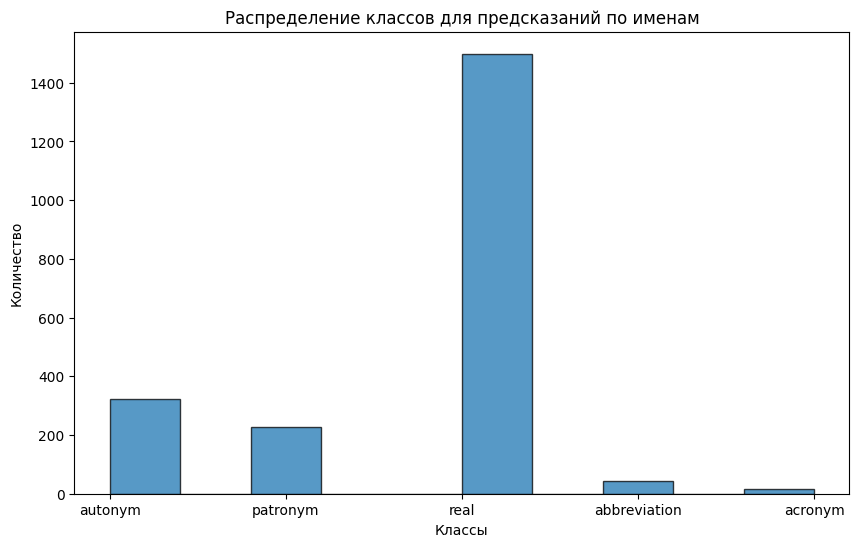

In [ ]:
# Строим гистограмму распределения классов
plt.figure(figsize=(10, 6))
plt.hist(dataset['predictions'], alpha=0.75, edgecolor='black')
plt.title('Распределение классов для предсказаний по именам')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

Как мы видим по данным гистограммы преобладают реальные имя-фамилия.

#Как распределяются типы никнеймов в группе пользователей-девушек?
---
#Как распределяются типы никнеймов в группе пользователей-юношей?


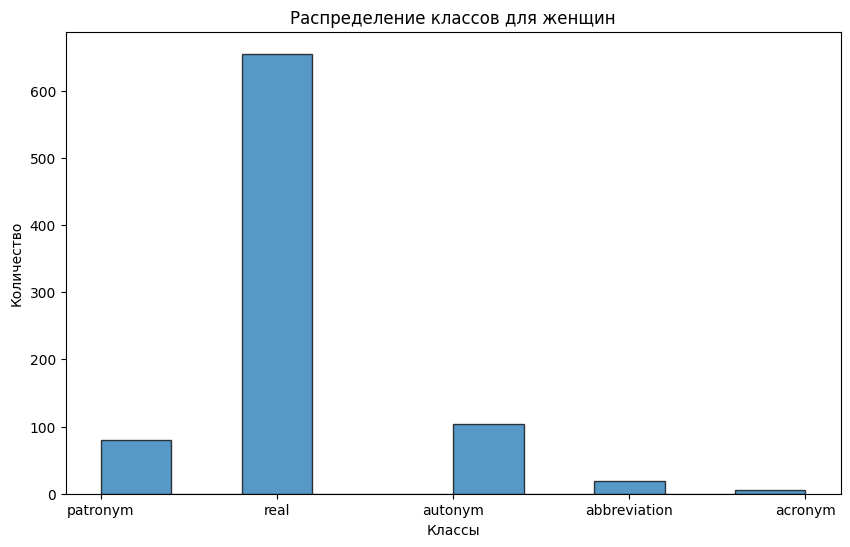

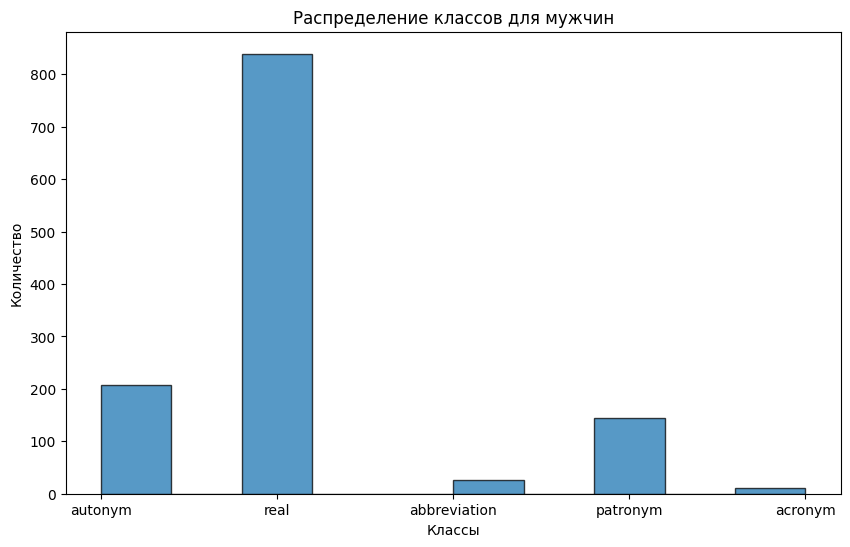

In [ ]:
# Разделяем DataFrame на два: для женщин и для мужчин
female_data = dataset[dataset['sex'] == 1]
male_data = dataset[dataset['sex'] == 2]

# Строим гистограмму для женщин
plt.figure(figsize=(10, 6))
plt.hist(female_data['predictions'], edgecolor='black', alpha=0.75)
plt.title('Распределение классов для женщин')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

# Строим гистограмму для мужчин
plt.figure(figsize=(10, 6))
plt.hist(male_data['predictions'], edgecolor='black', alpha=0.75)
plt.title('Распределение классов для мужчин')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

Судя по данным гистограмм, вне зависимости от пола, преобладают реальные имя-фамилия. Наблюдаем, что у девушек меньше используются патронимы и автонимы.

#Есть ли различия в частотности никнеймов, обусловленные типом образования?

In [13]:
datasetuniv = pd.read_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/userswithunivs.json')
datasetuniv['text'] = datasetuniv['first_name'].fillna('') + ' ' + datasetuniv['last_name'].fillna('')
print(datasetuniv.columns)

Index(['id', 'university_class', 'first_name', 'last_name', 'text'], dtype='object')


In [14]:
datasetuniv['predictions'] = datasetuniv['text'].apply(make_prediction)

In [15]:
# Сохранение результата
datasetuniv.to_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/userswithunivsandpred.json', orient='records', force_ascii=False)

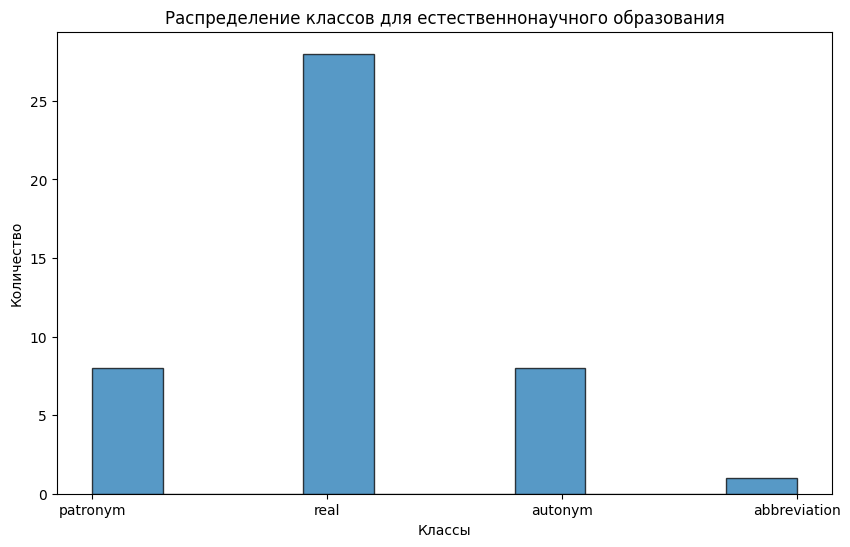

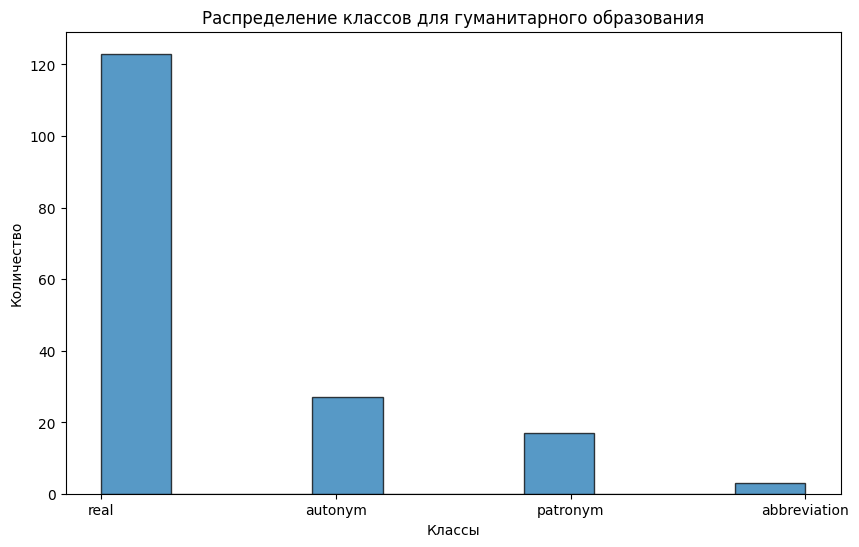

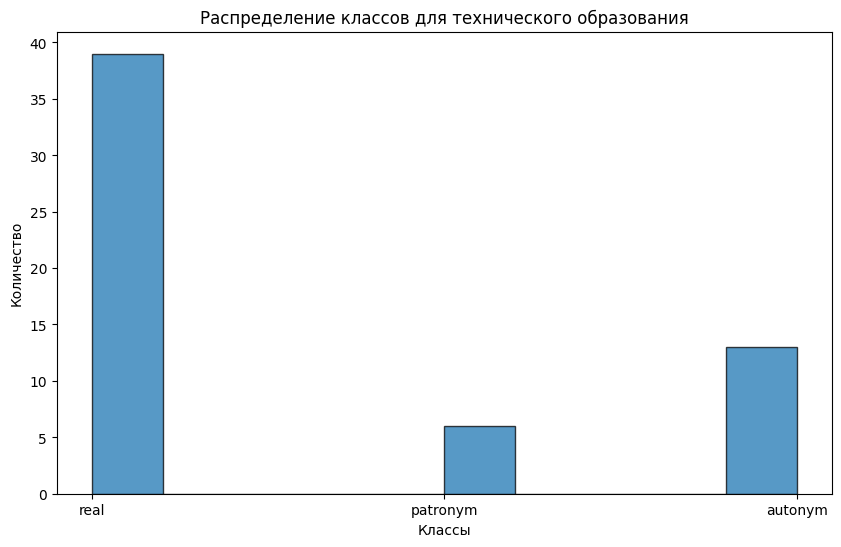

In [6]:
# Разделяем DataFrame
scientific_data = datasetuniv[datasetuniv['university_class'] == 'Scientific']
humanistic_data = datasetuniv[datasetuniv['university_class'] == 'Humanistic']
technic_data = datasetuniv[datasetuniv['university_class'] == 'Technic']

# Строим гистограммы
plt.figure(figsize=(10, 6))
plt.hist(scientific_data['predictions'], edgecolor='black', alpha=0.75)
plt.title('Распределение классов для естественнонаучного образования')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(humanistic_data['predictions'], edgecolor='black', alpha=0.75)
plt.title('Распределение классов для гуманитарного образования')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(technic_data['predictions'], edgecolor='black', alpha=0.75)
plt.title('Распределение классов для технического образования')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

В данном случае так же наблюдается преобладание реальных имя-фамилия, а так же выделяются автонимы и патронимы. Наличие аббревиатур указывает на то, что присутствуют наборы несвязанных между собой букв (соотносится с наличием естественнонаучного и гуманитарного образования). Убедиться в этом можно осмотрев датасет вручную.


#Можно ли указать особенности предпочтений при выборе/создании никнейма, связанные с национальностью?

In [45]:
nation = pd.read_json('/content/drive/MyDrive/Colab Notebooks/ForNeural2/nations.json')

In [46]:
nation.head()

,city,text,predictions,nation
0,Krasnoyarsk,Dima Kotov,real,Russia
1,Kharkiv,Sweet Home,autonym,Ukraine
2,Moscow,Qr Tress,abbreviation,Russia
3,Yaroslavl,Ohiko Kasumiishi,real,Russia
4,Kasimov,Ekaterina Afanasyeva,real,Russia


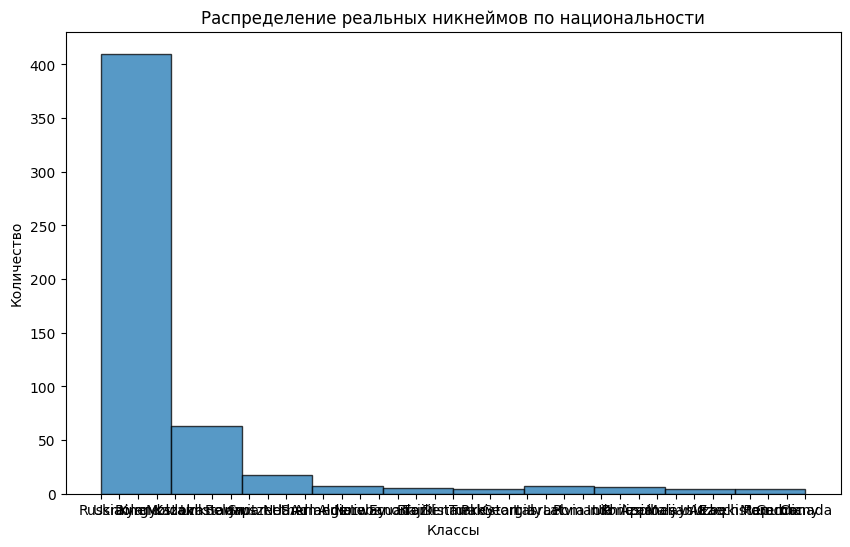

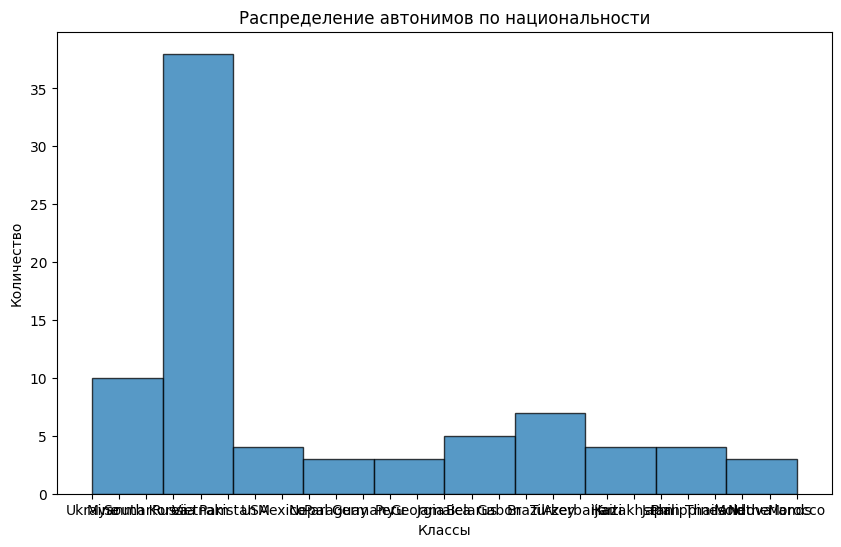

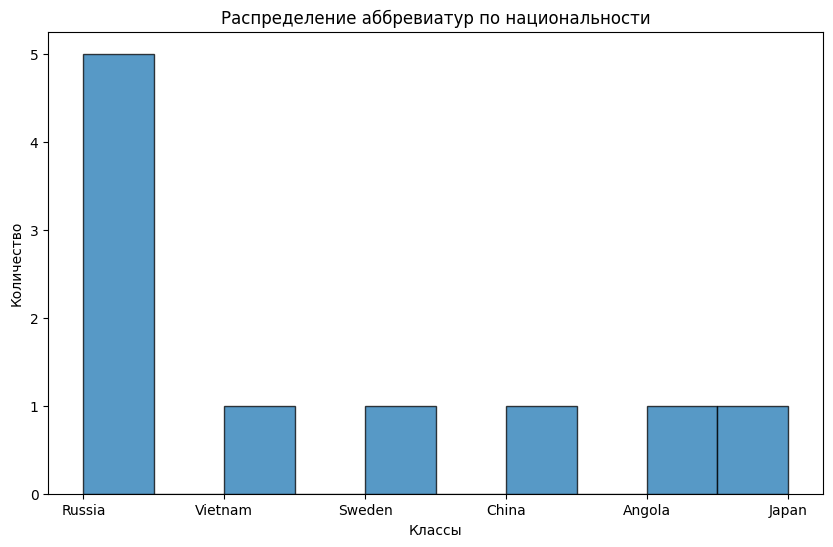

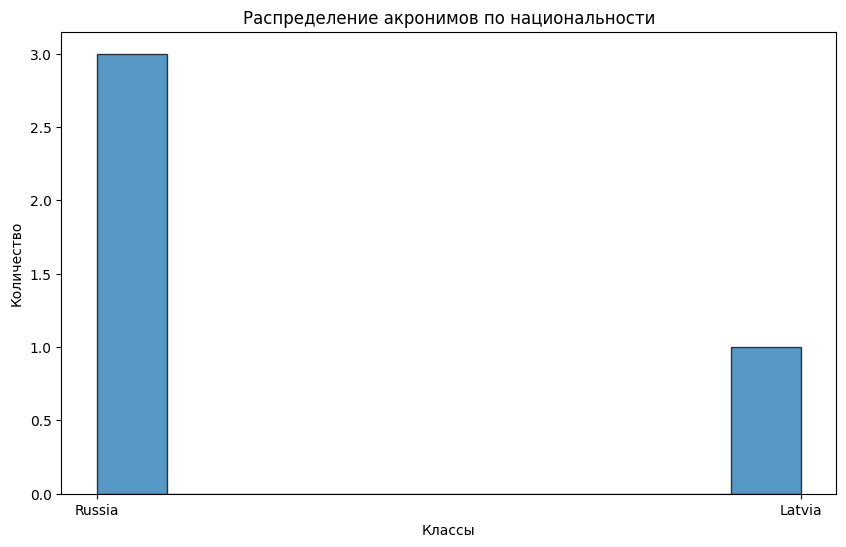

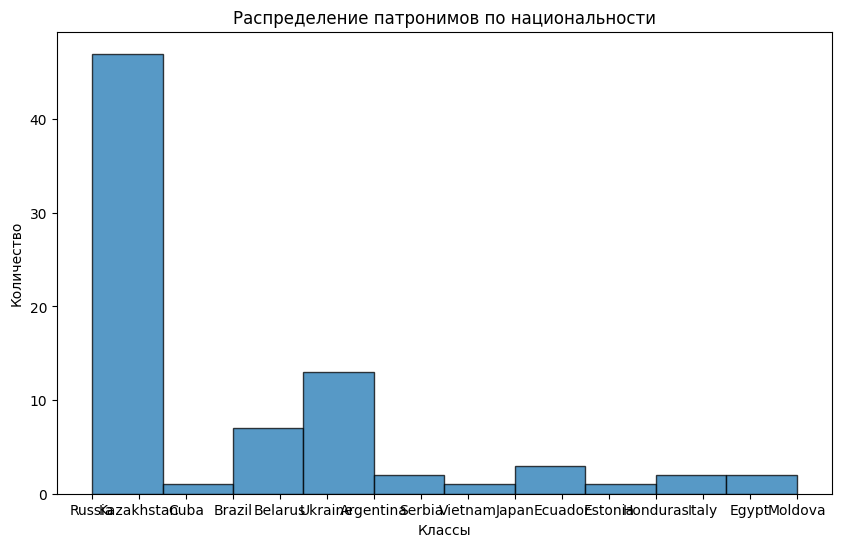

In [47]:
# Разделяем DataFrame
real_data = nation[nation['predictions'] == 'real']
autonym_data = nation[nation['predictions'] == 'autonym']
abbreviation_data = nation[nation['predictions'] == 'abbreviation']
acronym_data = nation[nation['predictions'] == 'acronym']
patronym_data = nation[nation['predictions'] == 'patronym']

# Строим гистограммы
plt.figure(figsize=(10, 6))
plt.hist(real_data['nation'], edgecolor='black', alpha=0.75)
plt.title('Распределение реальных никнеймов по национальности')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(autonym_data['nation'], edgecolor='black', alpha=0.75)
plt.title('Распределение автонимов по национальности')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(abbreviation_data['nation'], edgecolor='black', alpha=0.75)
plt.title('Распределение аббревиатур по национальности')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(acronym_data['nation'], edgecolor='black', alpha=0.75)
plt.title('Распределение акронимов по национальности')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(patronym_data['nation'], edgecolor='black', alpha=0.75)
plt.title('Распределение патронимов по национальности')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

Как мы видим по гистограммам вне зависимости от национальности преобладают реальные имя-фамилия. Патронимы так же имеют значение. Аббревиатуры, хоть их и мало, относятся в основном к азиатскому региону. Однако стоит учесть погрешность социальной сети ВК, где пользователи могут указать абсолютно любой город в качестве родного. Так что в целом, использование различных классов никнеймов не зависит от национальности. В приоритете по всему исследованию мы наблюдаем использование реальных имя-фамилии.